# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
api_key = ApiKeyStore().get_api_key("GOOGLE/PALM")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
# from vanna.openai import OpenAI_Chat
from vanna.google import GoogleGeminiChat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = 'gemini-1.5-pro'  
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, GoogleGeminiChat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        GoogleGeminiChat.__init__(self, config=config)
        

In [5]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [6]:
vn = MyVanna(config=CONFIG)

/home/gongai/anaconda3/envs/vanna/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: ducklover1


In [8]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [9]:
vn.run_sql_is_set

True

In [10]:
if clean_and_train:
    remove_collections()

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE sqlite_sequence(name,seq)
Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)
Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TAB

## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up





# QUESTION :  How many customers are there



[( EXTRACTED SQL )]
SELECT COUNT(*) FROM customers;


[( <SQL> )]
generated SQL statement



SELECT COUNT(*) FROM customers;


[( <DataFrame> )]
queried dataframe



,COUNT(*)
0,59



[( <Python> )]
generated Plotly code



import plotly.graph_objects as go

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['COUNT(*)'].iloc[0],
    ))
else:
    fig = go.Figure([go.Bar(x=df.index, y=df['COUNT(*)'])])

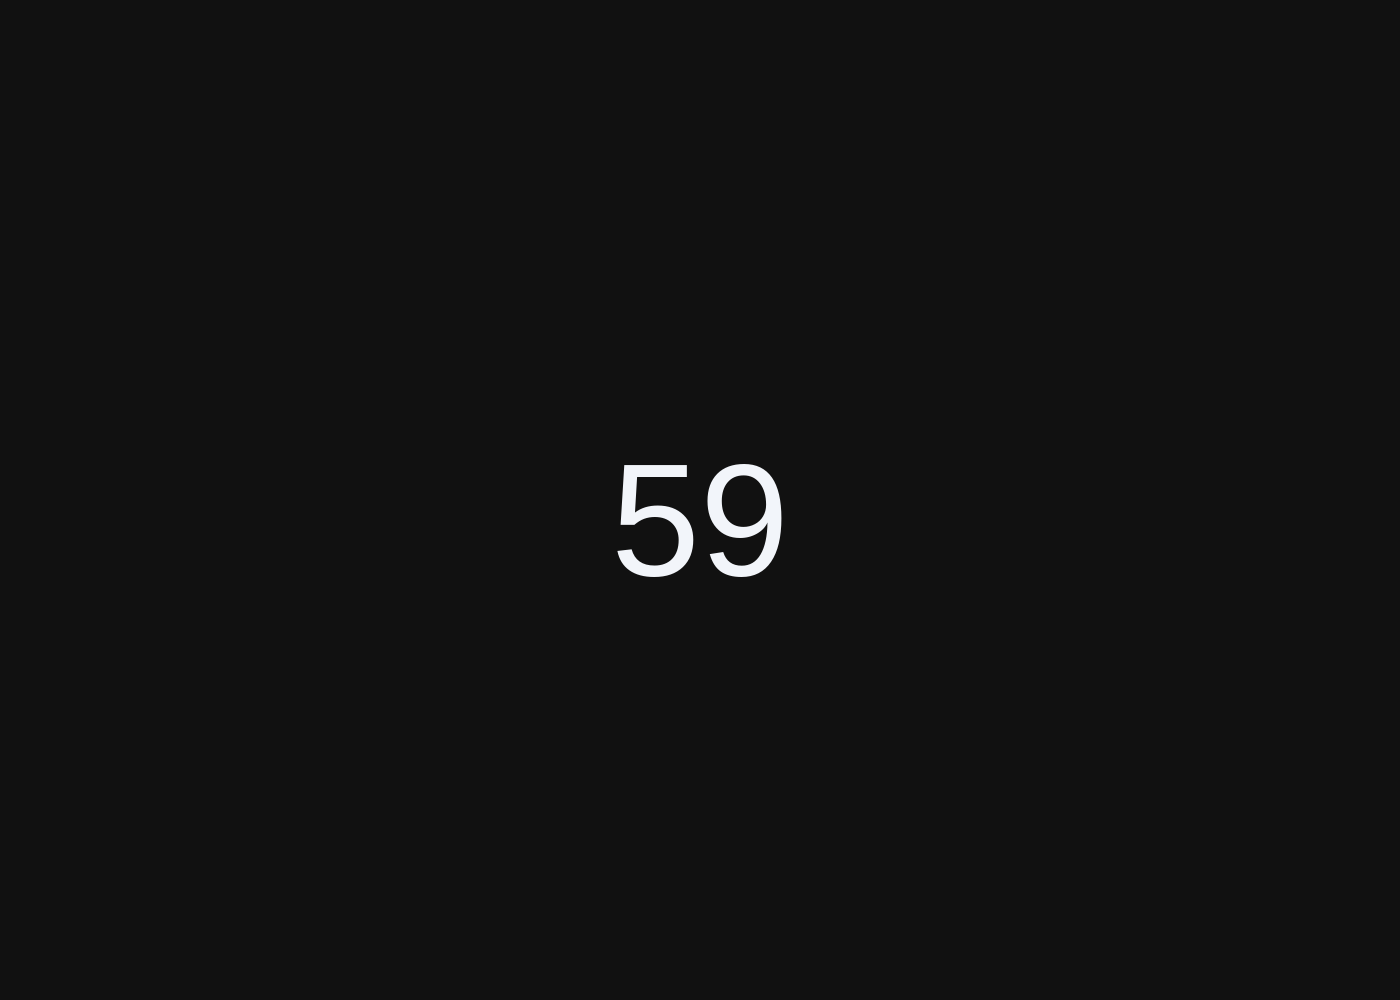

elapsed_time = 3.827850580215454


In [15]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
### Loop over questions

In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?



[( EXTRACTED SQL )]
SELECT name FROM sqlite_master WHERE type='table';


[( <SQL> )]
generated SQL statement



SELECT name FROM sqlite_master WHERE type='table';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,sqlite_sequence
2,artists
3,customers
4,employees
5,genres
6,invoices
7,invoice_items
8,media_types
9,playlists



[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import plotly.express as px

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['name'].iloc[0],
        title={"text": "Table Name"}
    ))
elif len(df['name'].unique()) == len(df):
    fig = px.bar(df, x='name', title="Table Names")
else:
    fig = px.bar(df, x='name', title="Table Names (with counts)")

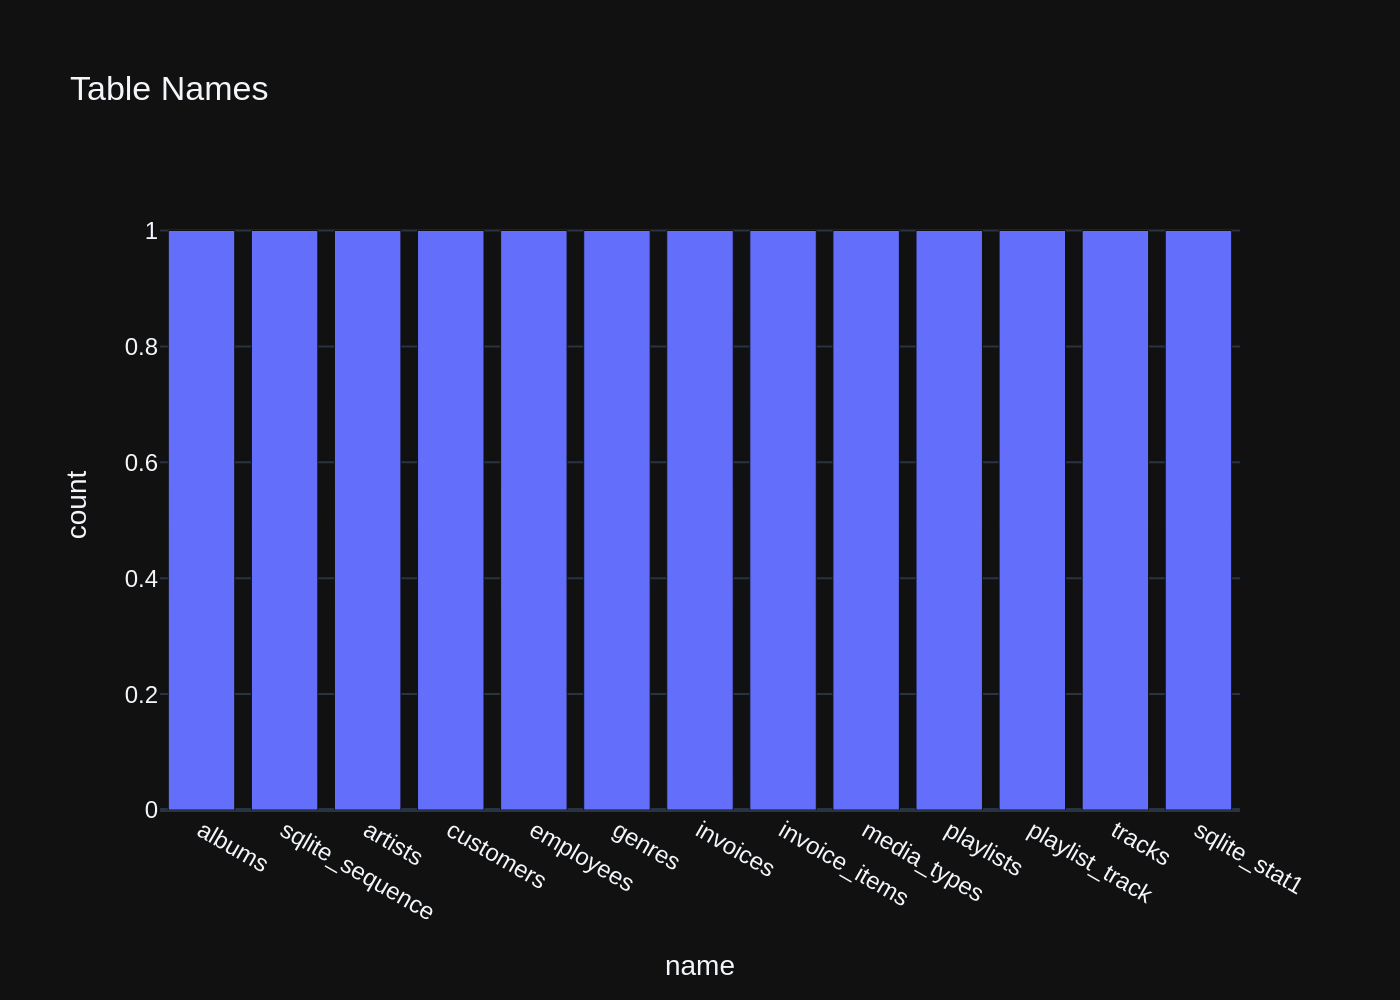





# QUESTION  - 3:  which table stores customer's orders



[( EXTRACTED SQL )]
sqlite
SELECT name FROM sqlite_master WHERE type='table' AND name LIKE '%invoice%'



[( RETRY )]
***** 1 *****

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: which table stores customer's orders
                    results in the following error: [ERROR-SQL] the generated SQL : sqlite
SELECT name FROM sqlite_master WHERE type='table' AND name LIKE '%invoice%'

 does not starts with ('select','with') .
                    Can you try to fix the error and re-generate the SQL statement?
                 with the following exception: 
429 Resource has been exhausted (e.g. check quota).

[( RETRY )]
***** 2 *****

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: 
                    Generating SQL for this question: which table stores customer's orders
                    results in the following error

SELECT FirstName, LastName FROM customers EXCEPT SELECT T1.FirstName, T1.LastName FROM customers AS T1 INNER JOIN invoices AS T2 ON T1.CustomerId = T2.CustomerId


[( <DataFrame> )]
queried dataframe



,FirstName,LastName






# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    



[( EXTRACTED SQL )]
SELECT T2.Name FROM tracks AS T1 INNER JOIN artists AS T2 ON T1.AlbumId = T2.ArtistId GROUP BY T2.Name ORDER BY COUNT(T1.TrackId) DESC LIMIT 10



[( <SQL> )]
generated SQL statement



SELECT T2.Name FROM tracks AS T1 INNER JOIN artists AS T2 ON T1.AlbumId = T2.ArtistId GROUP BY T2.Name ORDER BY COUNT(T1.TrackId) DESC LIMIT 10


[( <DataFrame> )]
queried dataframe



,Name
0,The Police
1,Frank Zappa & Captain Beefheart
2,Vinícius E Qurteto Em Cy
3,Boston Symphony Orchestra & Seiji Ozawa
4,Fretwork
5,Aaron Copland & London Symphony Orchestra
6,Ton Koopman
7,Falamansa
8,Calexico
9,Yehudi Menuhin



[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['Name'].iloc[0],
        title={"text": "Top Artist"}
    ))
else:
    fig = go.Figure([go.Bar(x=df['Name'], y=df.index)])
    fig.update_layout(xaxis_title="Artist", yaxis_title="Rank", title="Top 10 Artists by Number of Tracks")

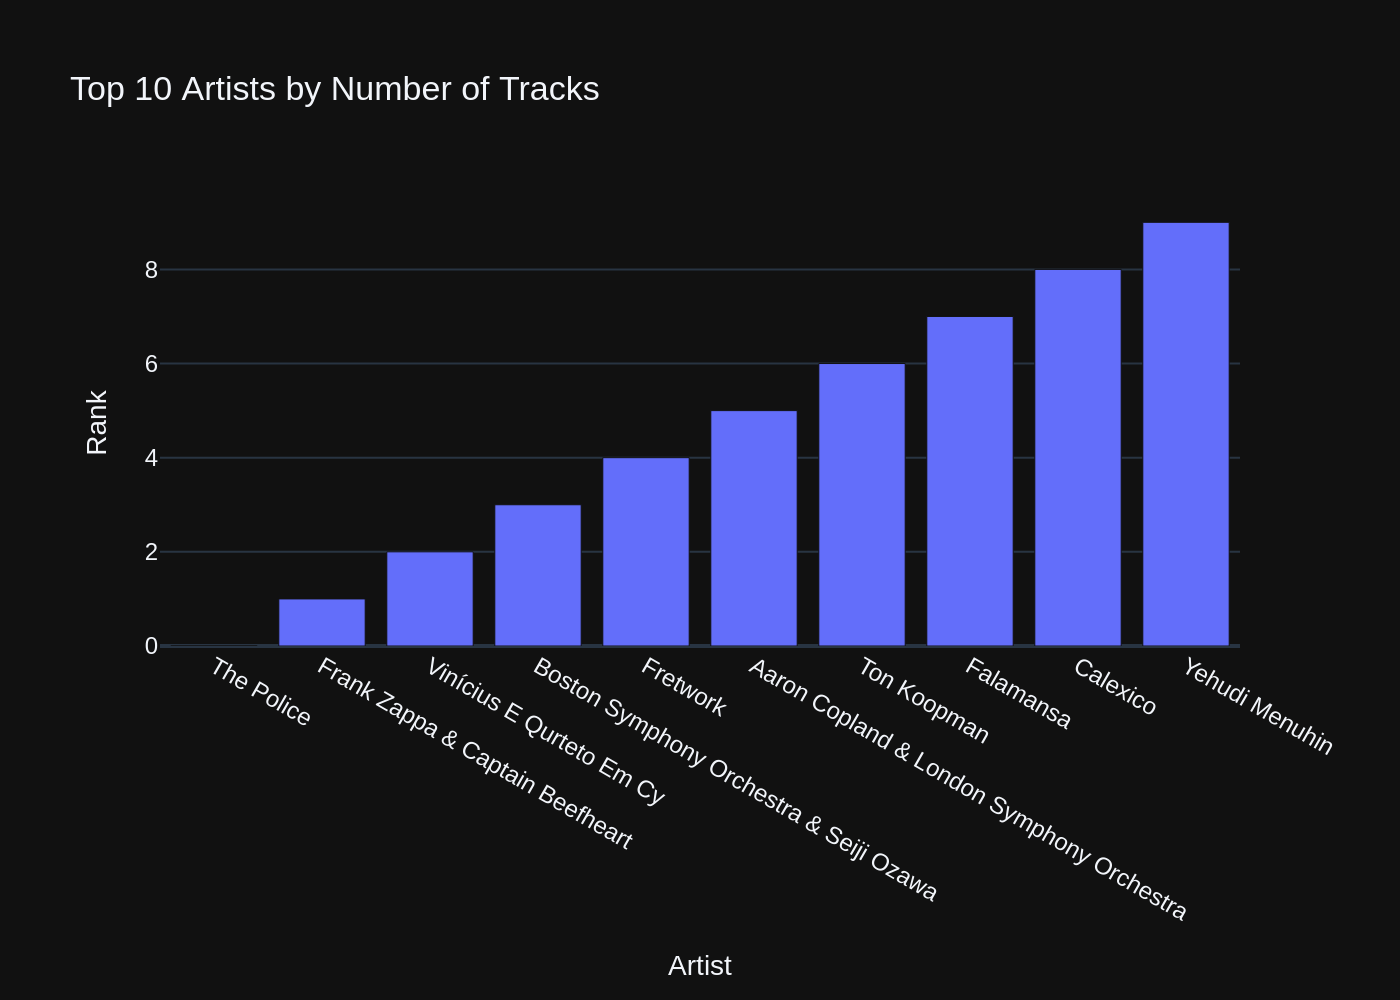





# QUESTION  - 19:  List all customers from Canada and their email addresses:


[ERROR-SQL] Failed to generate SQL for prompt: List all customers from Canada and their email addresses: with the following exception: 
429 Resource has been exhausted (e.g. check quota).

[( RETRY )]
***** 1 *****

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: List all customers from Canada and their email addresses:
                    results in the following error: [ERROR-SQL] Failed to generate SQL for prompt: List all customers from Canada and their email addresses: with the following exception: 
429 Resource has been exhausted (e.g. check quota). .
                    Can you try to fix the error and re-generate the SQL statement?
                 with the following exception: 
429 Resource has been exhausted (e.g. check quota).

[( RETRY )]
***** 2 *****


[( EXTRACTED SQL )]
sqlite
SELECT FirstName, LastName, Email FROM customers WHERE Coun

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'gemini-1.5-pro' 
 took 89 sec
 run on 'ducklover1' 
 at 20241122-231803


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-gemini-1.5-pro-89s-ducklover1-20241122-231803.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,5e526ae4-4473-5cc5-9185-b16c465687c0-sql,How many customers are there,SELECT COUNT(*) FROM customers LIMIT 20,sql
1,9f52b00e-4ebd-5eda-b218-51645a2fbdc1-sql,Can you list all tables in the SQLite database...,SELECT name FROM sqlite_master WHERE type='tab...,sql
2,f442f0ab-f1f9-537b-b829-6e6b35e5231d-sql,\n Can you find the top 10 most popula...,SELECT T2.Name FROM tracks AS T1 INNER JOIN ar...,sql
0,039f9d54-59f7-5f29-8c04-14dbc3e95671-ddl,None,"CREATE TABLE ""artists""\r\n(\r\n ArtistId IN...",ddl
1,0db84e3d-ef41-563c-803e-21c1b985dc19-ddl,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
2,10cba811-ddba-5042-9e90-d764dfcd1629-ddl,None,"CREATE INDEX IFK_InvoiceCustomerId ON ""invoice...",ddl
3,2c711317-b93d-5f60-a728-cb1c6fcbc040-ddl,None,"CREATE INDEX IFK_CustomerSupportRepId ON ""cust...",ddl
4,37319c81-65f7-50ee-956b-795de244bee5-ddl,None,"CREATE TABLE sqlite_stat1(tbl,idx,stat)",ddl
5,40bd77cd-e1de-5872-8693-624117ff413c-ddl,None,"CREATE INDEX IFK_InvoiceLineInvoiceId ON ""invo...",ddl
6,41130543-7164-562a-90a7-0fd0a409c154-ddl,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl


In [22]:
df_training_data.to_csv(file_csv, index=False)